In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


## 导入必要的库

In [45]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from colorama import Fore, Style, init

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import mutual_info_classif

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## 读取数据

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
train_df = train_df.set_index("id")
test_df = test_df.set_index("id")

## 常用函数

In [39]:
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + style)

# 字典编码函数  排序映射赋值（有序离散object处理）
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value),index=value))).values
# 多变量分析  将两个变量融合进而分析
def combine_feature(df):
    cols = df.columns
    feature1 = df[cols[0]].astype(str).values.tolist()
    feature2 = df[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i] + '&' + feature2[i] for i in range(df.shape[0])])

## EDA

In [38]:
# Train
PrintColor(f"\nTrain set head", color = Fore.BLUE)
display(train_df.head(5).style.format(precision = 3))
PrintColor(f"\nTrain set description", color = Fore.BLUE)
display(train_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\nTrain set Information", color = Fore.BLUE)
display(train_df.info())

# Test
PrintColor(f"\nTest set head", color = Fore.BLUE)
display(test_df.head(5).style.format(precision = 3))
PrintColor(f"\Test set description", color = Fore.BLUE)
display(test_df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).transpose().
                            drop(columns = ['count'], errors = 'ignore').
                            style.format(formatter = '{:,.2f}').
                            background_gradient(cmap = 'Purples'))
PrintColor(f"\Test set Information", color = Fore.BLUE)
display(test_df.info())


Train set head


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.100,132.000,24.000,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.500,decreased,distend_small,57.000,8.500,serosanguious,3.400,yes,2209,0,0,no,died
1,yes,adult,533836,37.500,88.000,12.000,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.000,absent,distend_small,33.000,64.000,serosanguious,2.000,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.300,120.000,28.000,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.500,nan,distend_large,37.000,6.400,serosanguious,3.400,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.100,72.000,30.000,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.000,decreased,distend_small,53.000,7.000,cloudy,3.900,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.000,52.000,48.000,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.000,normal,normal,47.000,7.300,cloudy,2.600,no,0,0,0,yes,lived



Train set description


,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
hospital_number,"954,500.40","1,356,403.14","521,399.00","527,563.00","528,800.00","529,777.00","534,145.00","535,330.00","5,290,409.00","5,299,603.00","5,305,129.00"
rectal_temp,38.20,0.79,35.40,37.10,37.80,38.20,38.60,39.30,39.50,40.30,40.80
pulse,79.57,29.11,30.00,42.00,53.00,76.00,100.00,114.00,129.00,164.00,184.00
respiratory_rate,30.05,16.45,8.00,12.00,18.00,28.00,36.00,48.00,60.00,90.00,96.00
nasogastric_reflux_ph,4.38,1.94,1.00,2.00,2.00,4.50,6.00,7.00,7.00,7.50,7.50
packed_cell_volume,49.60,10.54,23.00,34.70,43.00,48.00,57.00,66.00,69.00,75.00,75.00
total_protein,21.39,26.68,3.50,5.87,6.60,7.50,9.10,74.00,80.00,82.00,89.00
abdomo_protein,3.29,1.59,0.10,1.00,2.00,3.00,4.30,5.20,6.50,8.00,10.10
lesion_1,"3,832.50","5,436.73",0.00,0.00,"2,205.00","2,209.00","3,205.00","7,111.00","8,700.00","31,110.00","41,110.00"
lesion_2,14.61,193.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,112.00"



Train set Information
<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null  

None


Test set head


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1235,no,adult,534053,38.600,40.000,20.000,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,slight,none,none,7.000,normal,distend_small,42.000,7.500,clear,2.300,no,0,0,0,no
1236,yes,adult,528469,38.200,112.000,48.000,cool,reduced,bright_pink,more_3_sec,depressed,hypomotile,moderate,slight,none,3.500,decreased,distend_small,44.000,6.000,serosanguious,2.600,no,2208,0,0,yes
1237,yes,adult,528178,37.700,66.000,12.000,cool,normal,bright_red,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.000,normal,distend_small,31.500,6.000,cloudy,1.600,yes,2205,0,0,yes
1238,no,adult,534784,37.100,88.000,20.000,cool,reduced,pale_cyanotic,less_3_sec,depressed,absent,severe,slight,more_1_liter,2.000,absent,distend_large,75.000,81.000,nan,1.000,yes,1400,0,0,no
1239,yes,adult,529840,38.300,50.000,12.000,nan,normal,bright_pink,less_3_sec,mild_pain,absent,slight,slight,none,3.000,decreased,distend_small,37.000,6.800,cloudy,2.600,yes,2208,0,0,yes


\Test set description


,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
hospital_number,"1,108,357.20","1,555,626.92","521,399.00","527,680.15","528,743.00","529,808.50","534,644.00","5,287,179.00","5,291,243.50","5,299,603.00","5,305,129.00"
rectal_temp,38.24,0.79,36.00,37.10,37.80,38.20,38.60,39.20,39.50,40.30,40.80
pulse,80.23,29.16,36.00,44.00,54.00,76.00,100.00,114.00,132.00,164.00,184.00
respiratory_rate,30.72,17.43,9.00,12.00,18.00,28.00,36.00,50.70,68.00,90.00,96.00
nasogastric_reflux_ph,4.51,1.88,1.00,2.00,3.00,4.50,6.50,7.00,7.00,7.50,7.50
packed_cell_volume,49.06,10.45,23.00,33.00,43.00,48.00,55.00,65.00,69.00,75.00,75.00
total_protein,20.80,26.41,3.90,5.90,6.60,7.50,8.90,74.00,81.00,82.00,89.00
abdomo_protein,3.34,1.54,0.10,1.00,2.00,3.30,4.30,5.00,5.64,8.00,10.10
lesion_1,"3,709.80","5,112.93",0.00,0.00,"2,205.00","2,209.00","3,205.00","6,111.00","8,400.00","31,110.00","31,110.00"
lesion_2,12.39,197.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,300.00"


\Test set Information
<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                824 non-null    object 
 1   age                    824 non-null    object 
 2   hospital_number        824 non-null    int64  
 3   rectal_temp            824 non-null    float64
 4   pulse                  824 non-null    float64
 5   respiratory_rate       824 non-null    float64
 6   temp_of_extremities    789 non-null    object 
 7   peripheral_pulse       777 non-null    object 
 8   mucous_membrane        811 non-null    object 
 9   capillary_refill_time  818 non-null    object 
 10  pain                   795 non-null    object 
 11  peristalsis            805 non-null    object 
 12  abdominal_distention   802 non-null    object 
 13  nasogastric_tube       760 non-null    object 
 14  nasogastric_reflux     810 non-null  

None

## 1.hospital_number 有重复、出现数值很大的编号、是否应该当成离散量重新编一下码----独热编码
## 2.lesion_1、lesion_2、lesion_3数据比较有问题，需要如何处理

In [7]:
# 数据正确性验证
# 缺失值
# 异常值
# 规律性分析 （单变量分析、多变量分析）
# 离散型变量区分、名义型变量（男女-10）、有序（考虑是否当成连续）

In [31]:
# 缺失数据分析
PrintColor(f"\nTrain set null values", color = Fore.BLUE)
train_missing = train_df.isnull().sum() * 100 / len(train_df)
train_missing = train_missing[train_missing != 0]
train_missing = pd.DataFrame({'missing percent': train_missing})
train_missing = train_missing.sort_values('missing percent', ascending=False)
display(train_missing)
for col in train_missing.index:
    print(col,train_df[col].unique())#此处缺失值如何去补充
    
PrintColor(f"\nTest set null values", color = Fore.BLUE)
test_missing = test_df.isnull().sum() * 100 / len(test_df)
test_missing = test_missing[test_missing != 0]
test_missing = pd.DataFrame({'missing percent': test_missing})
test_missing = test_missing.sort_values('missing percent', ascending=False)
display(test_missing)
for col in test_missing.index:
    print(col,test_df[col].unique())#此处缺失值如何去补充


Train set null values


,missing percent
abdomen,17.246964
rectal_exam_feces,15.384615
nasogastric_tube,6.477733
peripheral_pulse,4.858300
abdomo_appearance,3.886640
pain,3.562753
temp_of_extremities,3.157895
abdominal_distention,1.862348
mucous_membrane,1.700405
nasogastric_reflux,1.700405


abdomen ['distend_small' 'distend_large' 'normal' 'firm' nan 'other']
rectal_exam_feces ['decreased' 'absent' nan 'normal' 'increased' 'serosanguious']
nasogastric_tube ['slight' 'none' 'significant' nan]
peripheral_pulse ['reduced' 'normal' nan 'absent' 'increased']
abdomo_appearance ['serosanguious' 'cloudy' 'clear' nan]
pain ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']
temp_of_extremities ['cool' 'cold' 'normal' 'warm' nan]
abdominal_distention ['slight' 'moderate' 'none' 'severe' nan]
mucous_membrane ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
nasogastric_reflux ['less_1_liter' 'more_1_liter' 'none' nan 'slight']
peristalsis ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']
capillary_refill_time ['more_3_sec' 'less_3_sec' nan '3']

Test set null values


,missing percent
abdomen,18.689320
rectal_exam_feces,15.169903
nasogastric_tube,7.766990
peripheral_pulse,5.703883
temp_of_extremities,4.247573
abdomo_appearance,3.762136
pain,3.519417
abdominal_distention,2.669903
peristalsis,2.305825
nasogastric_reflux,1.699029


abdomen ['distend_small' 'distend_large' nan 'other' 'firm' 'normal']
rectal_exam_feces ['normal' 'decreased' 'absent' nan 'increased']
nasogastric_tube ['none' 'slight' nan 'significant']
peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
abdomo_appearance ['clear' 'serosanguious' 'cloudy' nan]
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert']
abdominal_distention ['slight' 'moderate' 'severe' 'none' nan]
peristalsis ['hypomotile' 'absent' 'hypermotile' nan 'normal']
nasogastric_reflux ['none' 'more_1_liter' 'less_1_liter' nan]
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
capillary_refill_time ['less_3_sec' 'more_3_sec' nan '3']


## 1.缺失值数据均为object类型
## 2.缺失值数据中的nan，有些还有none的存在，应该如何处理nan。  检查了一下数据发现是大写的None和小写的none的问题？

In [36]:
# 寻找object类型、或者直接规定
dtypes = train_df.dtypes.to_dict()
cat_cols = []
num_cols = []
for column, typ in dtypes.items():
    if typ == "object":
        cat_cols.append(column)
    else:
        num_cols.append(column)
        
for col in cat_cols:
    print(col,train_df[col].unique())
    if col=='outcome':
        continue
    print(col,test_df[col].unique())

surgery ['yes' 'no']
surgery ['no' 'yes']
age ['adult' 'young']
age ['adult' 'young']
temp_of_extremities ['cool' 'cold' 'normal' 'warm' nan]
temp_of_extremities ['normal' 'cool' nan 'cold' 'warm']
peripheral_pulse ['reduced' 'normal' nan 'absent' 'increased']
peripheral_pulse ['normal' 'reduced' nan 'absent' 'increased']
mucous_membrane ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
mucous_membrane ['normal_pink' 'bright_pink' 'bright_red' 'pale_cyanotic' 'dark_cyanotic'
 'pale_pink' nan]
capillary_refill_time ['more_3_sec' 'less_3_sec' nan '3']
capillary_refill_time ['less_3_sec' 'more_3_sec' nan '3']
pain ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']
pain ['mild_pain' 'depressed' 'severe_pain' 'extreme_pain' nan 'moderate'
 'alert']
peristalsis ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']
peristalsis ['hypomotile' 'absent' 'hypermotile' nan 'normal']
abdominal_distention ['slight' 'moder

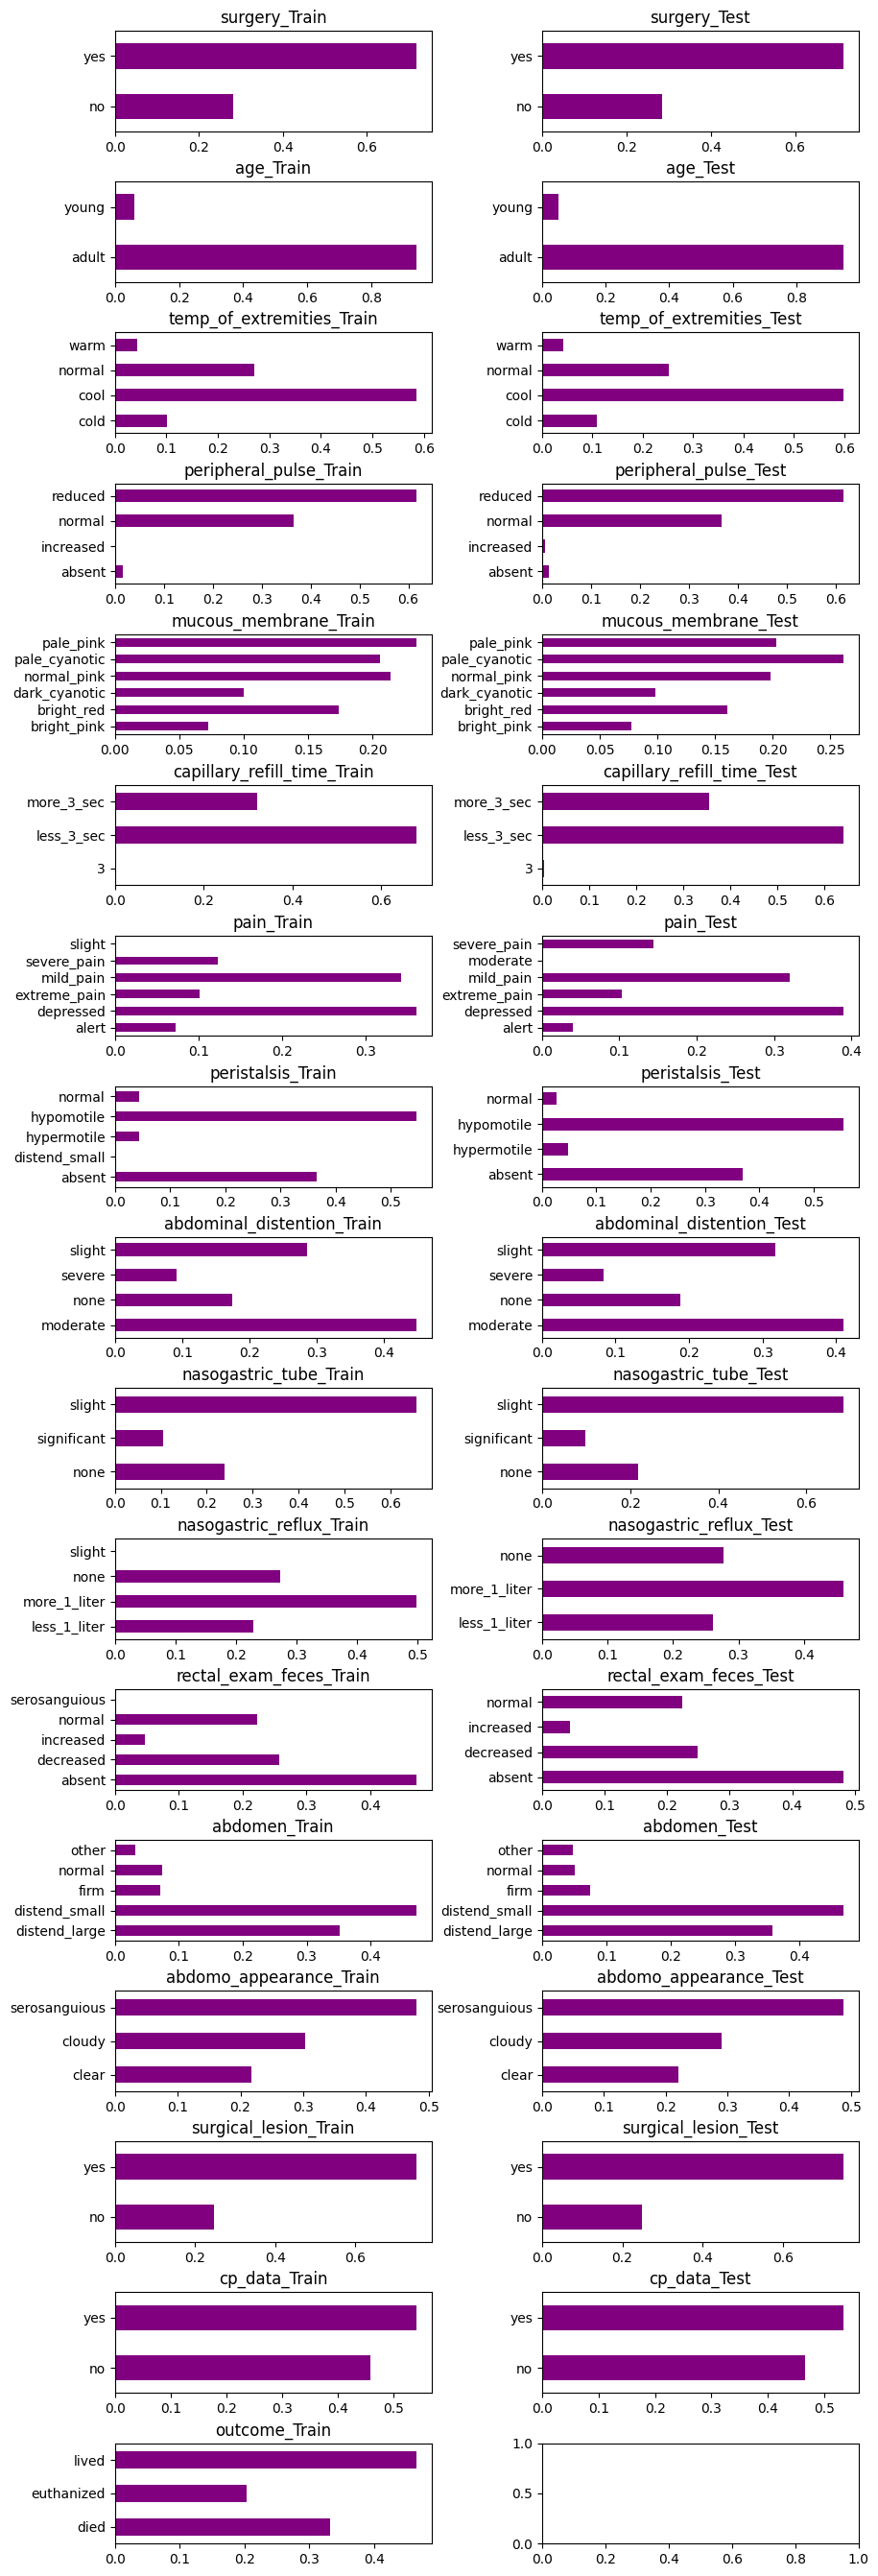

In [28]:
fig, axes = plt.subplots(len(cat_cols), 2, figsize = (10, len(cat_cols)* 2), 
                             gridspec_kw = {'wspace': 0.35, 'hspace': 0.5})
for i, column in enumerate(cat_cols):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    a = train_df[column].value_counts(normalize = True)
    a.sort_index().plot.barh(ax = ax1, color = 'purple')
    ax1.set_title(f"{column}_Train")
    ax1.set(ylabel = '')
    if column=='outcome':
        continue
    b = test_df[column].value_counts(normalize = True)
    b.sort_index().plot.barh(ax = ax2, color = 'purple')
    ax2.set_title(f"{column}_Test")
    ax2.set(ylabel = '')

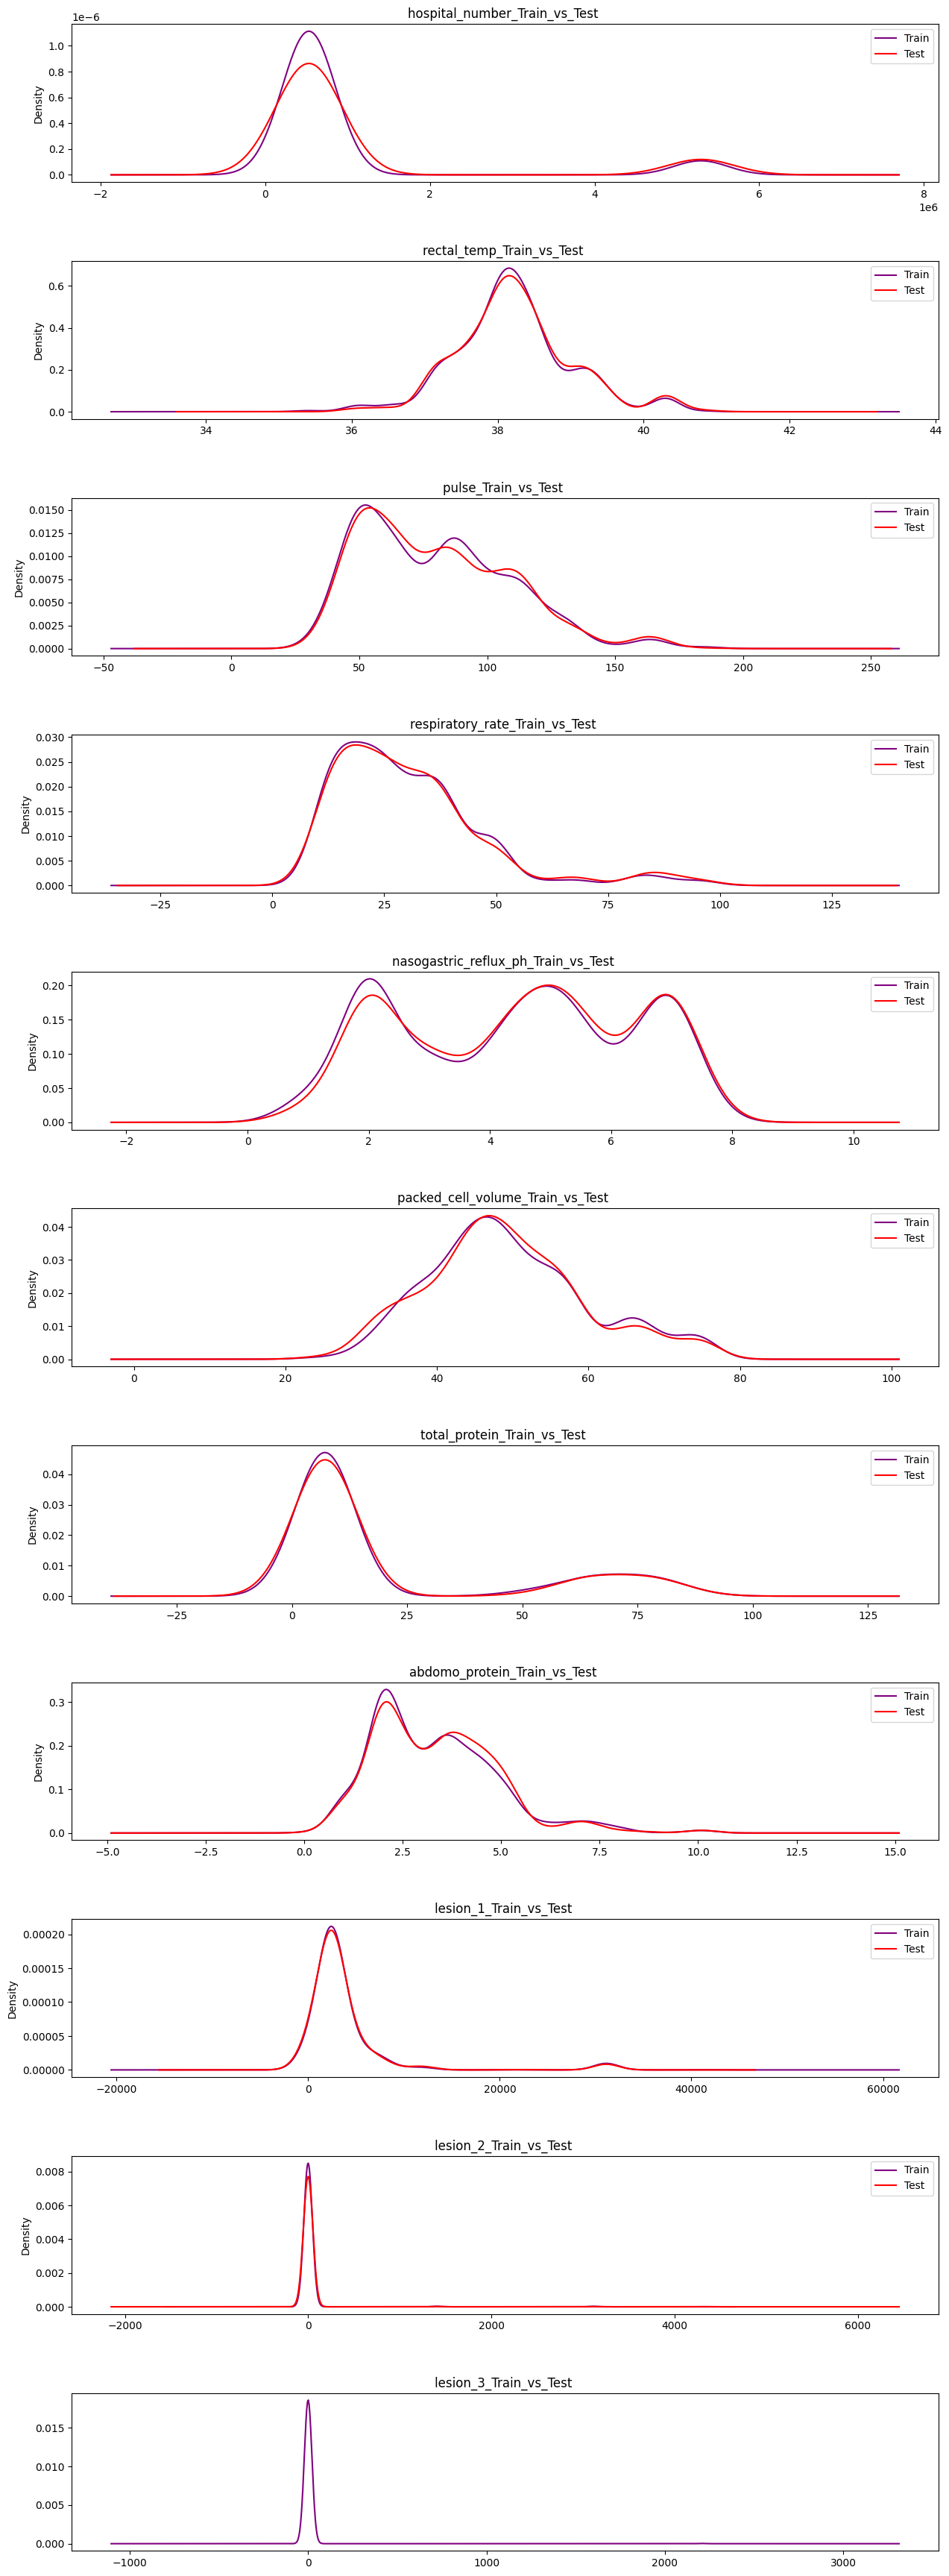

In [41]:
# 单变量分析
fig, axes = plt.subplots(len(num_cols), 1, figsize = (15, len(num_cols)* 4), 
                             gridspec_kw = {'wspace': 0.35, 'hspace': 0.5})
for i, column in enumerate(num_cols):
    ax1 = axes[i]
    a = train_df[column]
    a.plot(ax = ax1,kind='density', color = 'purple',label='Train')
    ax1.set_title(f"{column}_Train_vs_Test ")
    ax1.set(ylabel = '')
    if column=='lesion_3':
        continue
    b = test_df[column]
    b.plot(ax = ax1,kind='density', color = 'red',label='Test')
    ax1.legend(['Train','Test'])
# 多变量分析


## 1.单变量分析，训练集和测试集分布基本一致，除了hospital_number和lesion_3差别
## 2.hospital_number
## 3.lesion_3

<Axes: >

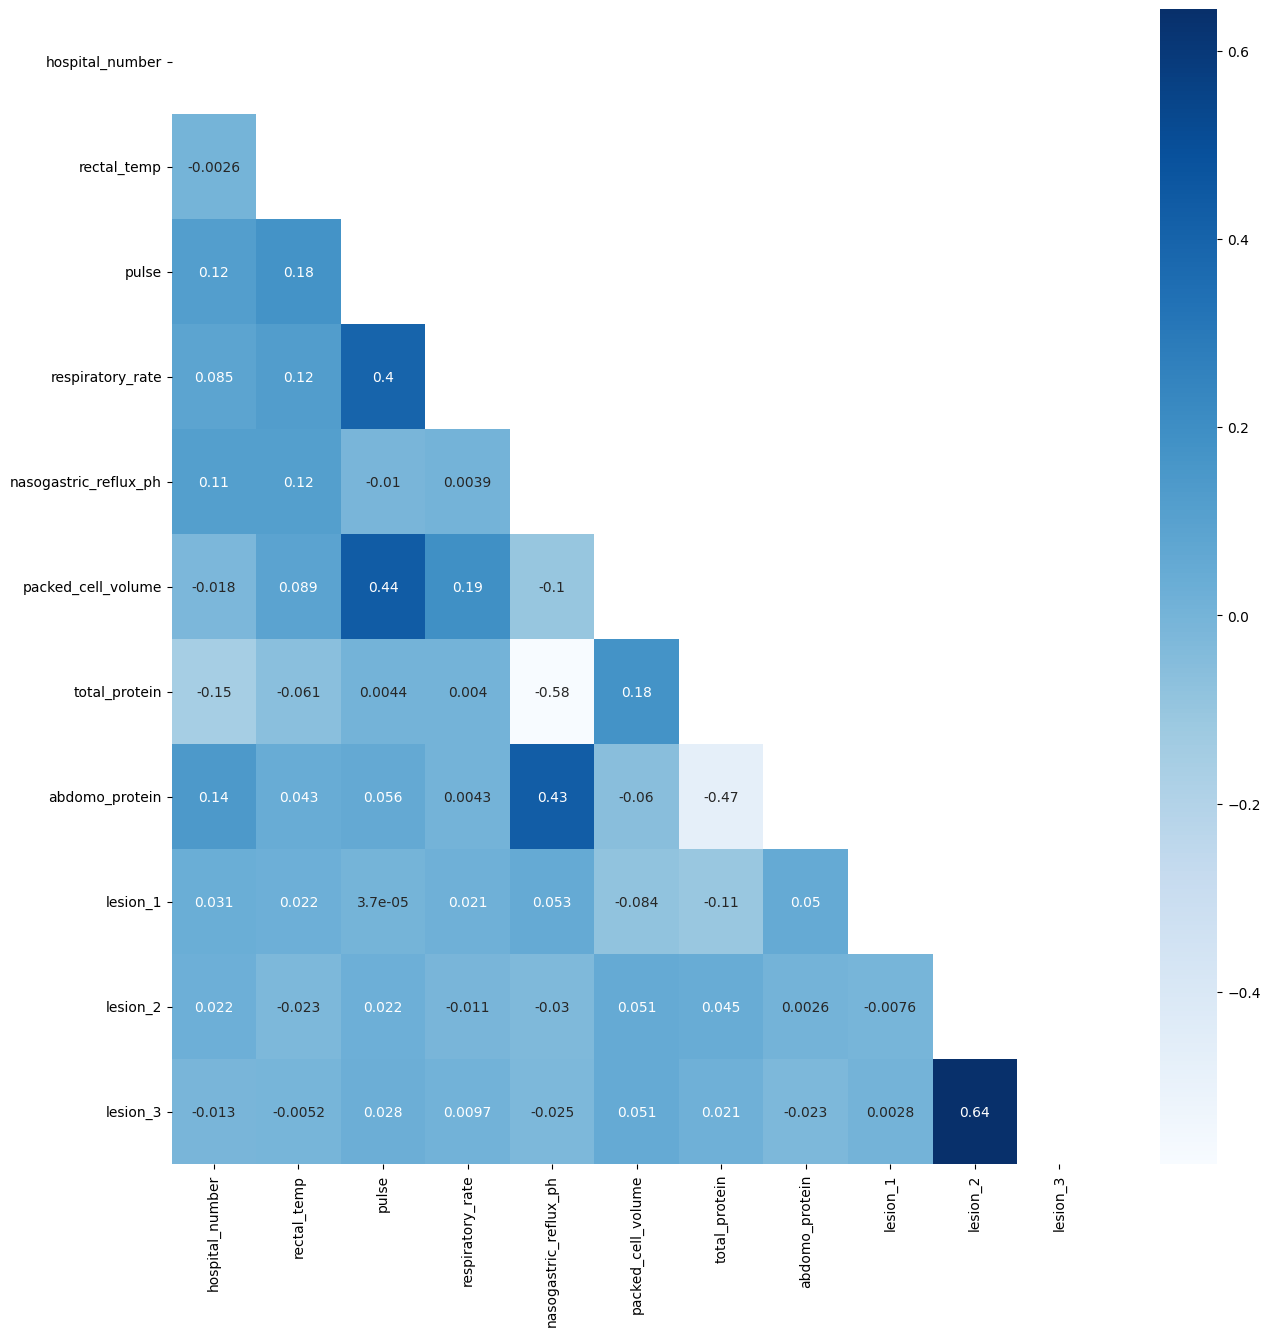

In [10]:
plt.figure(figsize=(15,15))
corr = train_df[num_cols].corr(method = "pearson")# 皮尔逊相关
mask = np.triu(np.triu(corr))
sns.heatmap(data = corr,annot=True, cmap = 'Blues', mask=mask)

## 1.pulse 和 respiratory_rate、packed_cell_volume正相关比较明显
## 2.nasogastric_reflux_ph 和total_protein、abdomo_protein分别呈负相关、正相关
## 3.total_protein和abdomo_protein呈正相关
## 4.lesion_2和lesion_3呈正相关

## **特征工程**

In [ ]:
## 
## 1.通用组合特征
## 2.业务统计特征

## **pipeline**

In [11]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant", fill_value="NaN")),
    ('encoder', OrdinalEncoder())
])
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols),
])
train_prepared = full_pipeline.fit_transform(train_df)
display(train_df)
display(pd.DataFrame(train_prepared))

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.313086,-0.129621,1.801773,-0.368142,1.093380,0.702421,-0.483319,0.068659,-0.298737,-0.075465,...,1.0,4.0,3.0,1.0,2.0,2.0,3.0,1.0,0.0,0.0
1,-0.310258,-0.890705,0.289582,-1.097830,-1.230314,-1.576449,1.598010,-0.812647,-0.298921,-0.075465,...,1.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,1.0
2,-0.313226,0.124074,1.389357,-0.124913,-0.455749,-1.196638,-0.562072,0.068659,0.237648,-0.075465,...,4.0,1.0,3.0,3.0,0.0,1.0,3.0,1.0,0.0,2.0
3,3.177363,-1.398095,-0.260306,-0.003299,-1.230314,0.322609,-0.539571,0.383411,-0.298921,-0.075465,...,4.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
4,3.204717,-0.256468,-0.947666,1.091232,1.351568,-0.247108,-0.528321,-0.434944,-0.705212,-0.075465,...,4.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,-0.309218,0.377769,1.698669,1.091232,-1.230314,0.702421,1.673013,-0.812647,-0.299289,-0.075465,...,1.0,1.0,1.0,2.0,0.0,1.0,3.0,1.0,0.0,2.0
1231,-0.314142,-0.890705,-0.672722,1.212846,-0.713937,-1.386544,-0.562072,0.194560,-0.298737,-0.075465,...,4.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,1.0,0.0
1232,-0.313319,-0.890705,0.152110,0.604774,-0.713937,-0.911779,-0.580823,2.334874,-0.631608,-0.075465,...,4.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,2.0
1233,-0.309559,-0.129621,-0.329042,-0.854601,-1.230314,0.797374,1.973025,-0.812647,-0.298737,-0.075465,...,4.0,4.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,2.0


## Pipline后分析

num__hospital_number          0.204613
num__nasogastric_reflux_ph    0.139928
cat__pain                     0.134444
num__respiratory_rate         0.082970
cat__peristalsis              0.058375
cat__temp_of_extremities      0.049805
cat__nasogastric_tube         0.033003
cat__nasogastric_reflux       0.023263
num__rectal_temp              0.006447
Name: MI Scores, dtype: float64

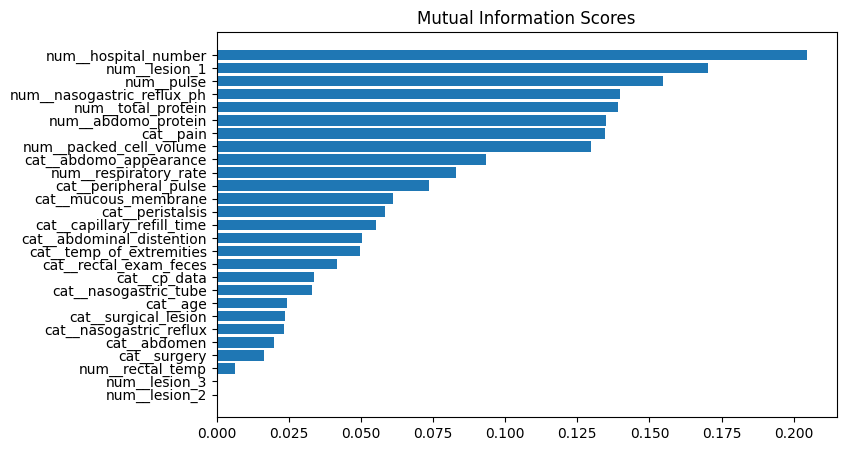

In [12]:
## 信息增益，互信息
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    columns = full_pipeline.get_feature_names_out()
    columns = np.delete(columns, len(columns) - 1)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = train_prepared[:, :-1].copy()
y = train_prepared[:, -1]

mi_scores = make_mi_scores(X, y)
display(mi_scores[::3]) # show a few features with their MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Text(0.5, 1.0, 'Distribution of hospital_number, by outcome')

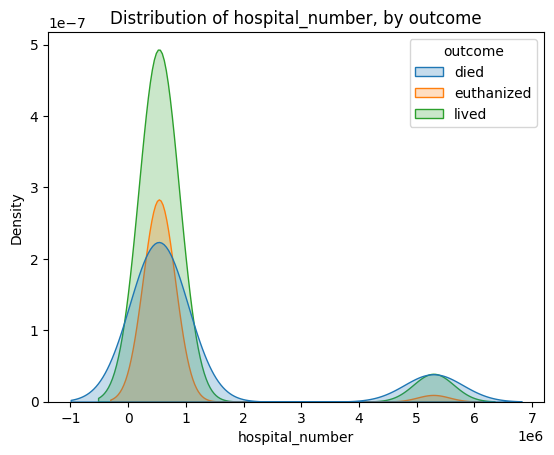

In [13]:
sns.kdeplot(data=train_df, x='hospital_number', hue='outcome', fill=True)
plt.title("Distribution of hospital_number, by outcome")

## PCA分析

In [14]:
train_X = train_prepared[:, :-1]
train_y = train_prepared[:, -1]
pca = PCA(n_components = 10)
X2D = pca.fit_transform(train_X)
display(pd.DataFrame(X2D))
display(pd.DataFrame(pca.explained_variance_ratio_))

,0,1,2,3,4,5,6,7,8,9
0,0.913096,1.349363,-1.968792,1.599768,1.118816,-1.152483,-0.099990,0.223414,-0.783595,-0.535450
1,2.420772,-1.491188,1.670365,0.078246,-0.447346,0.136814,0.120269,1.278742,-0.226876,1.112902
2,0.912153,-1.739407,-0.620371,-2.003718,-1.028914,0.532937,1.156852,-0.881855,0.763064,-0.762303
3,-0.081121,-2.050081,-0.510654,-1.817296,-0.132847,0.178933,0.306442,0.075688,0.006302,2.909835
4,-2.957274,0.240764,-1.817201,1.300389,-0.826232,1.460239,-0.099550,0.200734,-0.443910,2.308095
...,...,...,...,...,...,...,...,...,...,...
1230,4.644668,-0.525018,-0.329448,-0.168714,-1.117991,0.811562,-0.066924,-1.175039,-0.449279,0.275705
1231,-1.283380,-1.668536,0.108255,-0.096863,0.880189,-1.262757,0.447035,-0.939577,-0.388269,0.053676
1232,-2.512089,-0.752276,-0.761118,0.423627,1.212548,-1.258201,0.484841,-0.426642,-0.920084,0.638055
1233,-0.221184,1.204333,2.952433,0.809690,0.562341,-1.318640,0.806744,-1.677932,-0.736003,0.761648


,0
0,0.144249
1,0.110074
2,0.079153
3,0.074889
4,0.060510
5,0.059230
6,0.048815
7,0.044190
8,0.041443
9,0.037549


## 网格搜索相关